Expert Agent 1:
Episode 1, Reward: 1, Average Loss: 0.18931376498050945
Episode 2, Reward: 1, Average Loss: 0.19646956097340465
Episode 3, Reward: 0, Average Loss: 0.19119616371629003
Episode 4, Reward: 0, Average Loss: 0.20376110080338378
Episode 5, Reward: 0, Average Loss: 0.20628887992461215
Episode 6, Reward: 0, Average Loss: 0.20484262898758943
Episode 7, Reward: 0, Average Loss: 0.2043685325926184
Episode 8, Reward: 0, Average Loss: 0.19552531789345054
Episode 9, Reward: 1, Average Loss: 0.19505930451430908
Episode 10, Reward: 0, Average Loss: 0.19622386816327342
Episode 11, Reward: 1, Average Loss: 0.19759506881364522
Episode 12, Reward: 0, Average Loss: 0.18878064289563087
Episode 13, Reward: 1, Average Loss: 0.19934795654045853
Episode 14, Reward: 0, Average Loss: 0.19256202885085352
Episode 15, Reward: 1, Average Loss: 0.1970196392262892
Episode 16, Reward: 0, Average Loss: 0.19107338045331118
Episode 17, Reward: 0, Average Loss: 0.18990173531830962
Episode 18, Reward: 0, Ave

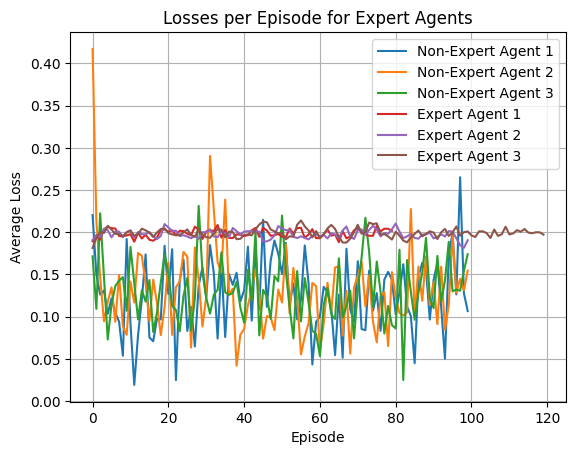

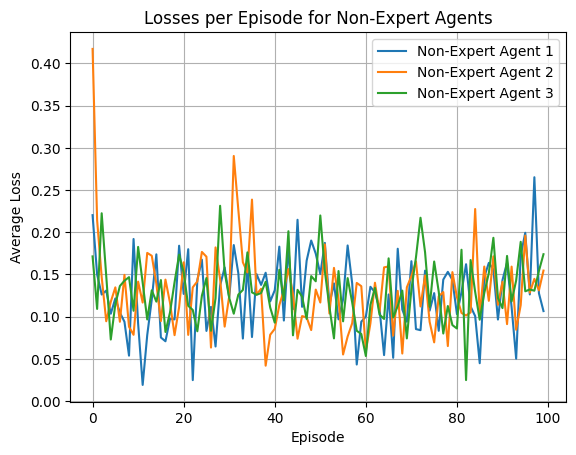

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pygame
import matplotlib.pyplot as plt

# Define your PongEnvironment class
class PongEnvironment:
    ACTION_SPACE = [0, 1]  # Define the action space

    def __init__(self, width=400, height=300):
        self.width = width
        self.height = height
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.clock = pygame.time.Clock()
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")
        self.reset()

    def step(self, action):
        self.move_paddle(action)
        self.ball_pos += self.ball_vel

        reward = 0  # Initialize reward to 0
        done = False  # Initialize done to False

        if self.ball_pos[1] <= self.ball_radius or self.ball_pos[1] >= self.height - self.ball_radius:
            self.ball_vel[1] *= -1

        if self.ball_pos[0] <= self.ball_radius:
            reward = 0  # Reward is 0 for missing the ball
            done = True
        elif self.ball_pos[0] >= self.width - self.ball_radius:
            if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                reward = 1  # Reward is 1 for hitting the ball
                self.ball_vel[0] *= -1
               # print("Ball hit the paddle!")
            else:
                reward = 0  # Reward is 0 for missing the ball
                done = True
              #  print("Ball missed the paddle!")

        # Check if the episode should be truncated
        if self.time_since_last_hit > 10000:  # 10 seconds in milliseconds
            done = True

        return self.get_state(), reward, done

    def reset(self):
        self.ball_pos = np.array([self.width // 2, random.randint(0, self.height)], dtype=float)
        self.ball_vel = np.array([random.uniform(0.03, 0.05), random.uniform(0.01, 0.03)], dtype=float)
        self.paddle_pos = self.height // 2
        self.time_since_last_hit = 0  # Reset timer
        return self.get_state()

    def move_paddle(self, action):
        paddle_speed = 5  # Adjust the speed of the paddle's movement as needed
        self.paddle_pos = np.clip(self.paddle_pos + action * paddle_speed, self.paddle_height / 2, self.height - self.paddle_height / 2)

    def get_state(self):
        return np.array([
            self.ball_pos[0] / self.width,
            self.ball_pos[1] / self.height,
            self.ball_vel[0],
            self.ball_vel[1],
            self.paddle_pos / self.height
        ], dtype=np.float32)  # Ensure consistent data type

    def render(self):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(self.screen, (255, 255, 255), pygame.Rect(0, self.paddle_pos - self.paddle_height / 2, self.paddle_width, self.paddle_height))
        pygame.draw.circle(self.screen, (255, 255, 255), (int(self.ball_pos[0]), int(self.ball_pos[1])), self.ball_radius)
        pygame.display.flip()

    def generate_expert_transitions(self, num_transitions=100):
        transitions = []

        for _ in range(num_transitions):
            action = np.random.choice(self.ACTION_SPACE)
            state = self.get_state()

            # Execute action in the environment
            self.move_paddle(action)
            next_state = self.get_state()

            # Determine reward and done
            reward = 0
            done = False

            # Check if the ball hits the paddle
            if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
                if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                    reward = 1  # Reward for hitting the ball
                else:
                    reward = 0  # No reward for missing the ball
                    done = True

            transitions.append((state, action, reward, next_state, done))

        return transitions


# Define the neural network for approximating the model Mθ
class ModelApproximator(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(ModelApproximator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.fc(x)


# Define the ReplayBuffer class with refined data processing for tensor conversion
class ReplayBuffer:
    def __init__(self, capacity, state_shape):
        self.buffer = deque(maxlen=capacity)
        self.state_shape = state_shape

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
        # Return default values if the buffer is empty or has insufficient data
            return self._default_batch(batch_size)

        batch = random.sample(self.buffer, batch_size)

    # Filter out None states and their corresponding data
        batch = [(s, a, r, ns, d) for s, a, r, ns, d in batch if s is not None and a is not None]
        if len(batch) == 0:
        # Return default values if all states are None
            return self._default_batch(batch_size)

    # Process the batch data for uniform shape and data type
        states, actions, rewards, next_states, dones = zip(*batch)

    # Pad states and next_states with zeros to ensure consistent shape
        states = self._pad_states(states)
        next_states = self._pad_states(next_states)

        actions = np.array(actions, dtype=np.int64)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)

        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        )


    def _pad_states(self, states):
        padded_states = []
        for state in states:
            if state is not None:
                padded_states.append(state)
            else:
                padded_states.append(np.zeros(self.state_shape, dtype=np.float32))
        return padded_states

    def _default_batch(self, batch_size):
        return (
            torch.FloatTensor(np.zeros((batch_size, *self.state_shape))),
            torch.LongTensor(np.zeros(batch_size)),
            torch.FloatTensor(np.zeros(batch_size)),
            torch.FloatTensor(np.zeros((batch_size, *self.state_shape))),
            torch.FloatTensor(np.zeros(batch_size))
        )

# Define the ExpertAgent class
class ExpertAgent:
    def __init__(self, env, index):
        self.env = env
        self.index = index  # Add index attribute
        state_shape = env.get_state().shape
        self.model = ModelApproximator(state_size=state_shape[0], action_size=len(env.ACTION_SPACE))
        self.replay_buffer = ReplayBuffer(capacity=10000, state_shape=state_shape)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)  # Define optimizer

    def train(self, num_episodes, batch_size):
        rewards_per_episode = []
        losses = []

        criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            episode_losses = []

            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)
                self.replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                if len(self.replay_buffer.buffer) >= batch_size:
                    states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
                    state_action_values = self.model(states)
                    loss = criterion(state_action_values, actions.view(-1))  # Flatten actions before passing to loss function
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    episode_losses.append(loss.item())

            rewards_per_episode.append(total_reward)
            losses.append(np.mean(episode_losses) if episode_losses else 0)
          #  print(f'Expert Agent {self.index} - Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        return rewards_per_episode, losses

    def test(self, num_episodes):
        rewards_per_episode = []

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0

            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)
                state = next_state
                total_reward += reward

            rewards_per_episode.append(total_reward)
          #  print(f'Expert Agent - Test Episode {episode}, Total Reward: {total_reward}')

        return rewards_per_episode

    def select_action(self, state, epsilon=0.1):
        if state is None:  # Handle None state
            return random.choice(range(len(self.env.ACTION_SPACE)))

        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0)
                action_values = self.model(state_t)
                action = np.argmax(action_values.cpu().numpy())
        else:
            action = random.choice(range(len(self.env.ACTION_SPACE)))
        return action

    def get_observations(self, num_samples=10):
        observations = []
        for _ in range(num_samples):
            state = self.env.reset()
            action = random.choice(self.env.ACTION_SPACE)
            next_state, reward, done = self.env.step(action)
            observations.append((state, action, reward, next_state, done))
        return observations

# Define the NonExpertAgent class
class NonExpertAgent:
    def __init__(self, env, expert_agents, index, alpha=1, abco_threshold=0.1):
        self.env = env
        self.index = index
        state_shape = env.get_state().shape
        self.model = ModelApproximator(state_size=state_shape[0], action_size=len(env.ACTION_SPACE))
        self.replay_buffer = ReplayBuffer(capacity=10000, state_shape=env.get_state().shape)
        self.expert_agents = expert_agents
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.alpha = alpha  # Store alpha parameter
        self.abco_threshold = abco_threshold  # Store abco_threshold parameter

    def train(self, num_episodes, batch_size):
        rewards_per_episode = []
        losses = []
        criterion = nn.CrossEntropyLoss()

        max_steps_per_episode = 1000  # Maximum steps per episode

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            episode_losses = []
            steps = 0  # Counter for steps in the current episode

            done = False
            while not done and steps < max_steps_per_episode:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)
                self.replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                steps += 1  # Increment step counter

                if len(self.replay_buffer.buffer) >= batch_size:
                    self.abco_correction(batch_size)
                    states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
                    state_action_values = self.model(states)
                    actions = actions.type(torch.LongTensor)  # Convert actions to LongTensor
                    loss = criterion(state_action_values, actions)  # Use CrossEntropyLoss for classification
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    episode_losses.append(loss.item())

            rewards_per_episode.append(total_reward)
            losses.append(np.mean(episode_losses) if episode_losses else 0)
           # print(f'Non-Expert Agent {self.index} - Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        return rewards_per_episode, losses

    def test(self, num_episodes):
        rewards_per_episode = []
        losses = []

        criterion = nn.CrossEntropyLoss()

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            episode_losses = []

            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(action)
                state = next_state
                total_reward += reward

                if len(self.replay_buffer.buffer) >= batch_size:
                    states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
                    state_action_values = self.model(states)
                    loss = criterion(state_action_values, actions.view(-1))  # Flatten actions before passing to loss function
                    episode_losses.append(loss.item())

            rewards_per_episode.append(total_reward)
            losses.append(np.mean(episode_losses) if episode_losses else 0)
            #print(f'Non-Expert Agent {self.index} - Test Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        return rewards_per_episode, losses

    def behavioral_cloning(self, transitions):
        states, actions, _, _, _ = zip(*transitions)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        criterion = nn.CrossEntropyLoss()
        self.optimizer.zero_grad()
        action_pred = self.model(states)
        loss = criterion(action_pred, actions)
        loss.backward()
        self.optimizer.step()

    def should_correct(self, state, next_state):
        # Refine success/failure criteria based on whether the ball hits the paddle or not
        if np.abs(state[0] - next_state[0]) < 1e-6:  # Check if x-coordinate remains almost the same
            if state[0] < self.env.width / 2 and next_state[0] >= self.env.width / 2:
                return True  # Ball hit the paddle
        return False

    def get_observations(self, num_samples=10):
        observations = []
        for _ in range(num_samples):
            state = self.env.get_state()
            action = random.choice(self.env.ACTION_SPACE)
            next_state, reward, done = self.env.step(action)
            observations.append((state, action, reward, next_state, done))
        return observations

    def abco_correction(self, batch_size):
        # Perform ABCO correction
        observations = self.get_observations(batch_size)
        for obs in observations:
            state, _, reward, next_state, done = obs
            if self.should_correct(state, next_state):
                self.replay_buffer.add(state, None, reward, next_state, done)

    def should_correct(self, state, next_state):
        # Compute similarity measure between state and next_state
        sim = np.linalg.norm(state - next_state)
        return sim < self.abco_threshold

    def select_action(self, state, epsilon=0.1):
        if state is None:  # Handle None state
            return random.choice(range(len(self.env.ACTION_SPACE)))

        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0)
                action_values = self.model(state_t)
                action = np.argmax(action_values.cpu().numpy())
        else:
            action = random.choice(range(len(self.env.ACTION_SPACE)))
        return action

# Main function with truncated output for ball hits in episodes
if __name__ == "__main__":
    pygame.init()
    env = PongEnvironment()

    # Adjust alpha and abco_threshold
    alpha = 100
    abco_threshold = 0.05

    expert_agents = [ExpertAgent(env, i) for i in range(3)]
    non_expert_agents = [NonExpertAgent(env, expert_agents, index, alpha=100, abco_threshold=0.05) for index in range(3)]


    num_episodes = 3
    batch_size = 32


    for index, expert_agent in enumerate(expert_agents):
        expert_rewards, expert_losses = expert_agent.train(num_episodes, batch_size)
        print(f'Expert Agent {index+1}:')
        for i, expert_reward in enumerate(expert_rewards):
            print(f'Episode {i+1}, Total Reward: {expert_reward}, Average Loss: {expert_losses[i]}')

    non_expert_rewards = []
    non_expert_losses = []
    for j, agent in enumerate(non_expert_agents):
        rewards, losses = agent.train(num_episodes, batch_size)
        non_expert_rewards.append(rewards)
        non_expert_losses.append(losses)
        print(f'Non-Expert Agent {j+1}:')
        for i, reward in enumerate(rewards):
            print(f'Episode {i+1}, Total Reward: {reward}, Average Loss: {losses[i]}')

    pygame.quit()

    # Plot rewards per episode for non-expert agents
    for j, rewards in enumerate(non_expert_rewards):
        plt.plot(rewards, label=f'Non-Expert Agent {j+1}')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode for Non-Expert Agents')
    plt.legend()
    plt.show()

    # Plot losses per episode for non-expert agents
    for j, losses in enumerate(non_expert_losses):
        plt.plot(losses, label=f'Non-Expert Agent {j+1}')

    plt.xlabel('Episode')
    plt.ylabel('Average Loss')
    plt.title('Losses per Episode for Non-Expert Agents')
    plt.legend()
    plt.grid(True)
    plt.show()
